In [1]:
import os
from io import BytesIO 
import lxml.html as html
from lxml import etree
from pandas import DataFrame
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import math
from sympy import Point, Polygon, Segment, convex_hull
%matplotlib inline

def normalise( vect ):
    len = math.sqrt( vect[0]*vect[0] + vect[1]*vect[1] )
    rvect = []
    if( len == 0 ): 
        rvect.append(vect[0])
        rvect.append(vect[1])
    else:
        rvect.append(vect[0]/len)
        rvect.append(vect[1]/len)
    # проверки
    if( math.isnan( rvect[0] ) or  math.isnan( rvect[1] ) ):
        print( "Component of rvect is nan", rvect, vect )
    if( math.isnan( vect[0] ) or  math.isnan( vect[1] ) ):
        print( "Component of vect is nan", rvect ) 
    if( math.isnan( len ) ):
        print ("Length is nan")
        print(vect)
    return rvect
    

def getAbsScalar( vect1, vect2 ):
    v1 = normalise(vect1)
    v2 = normalise(vect2)
    scalar = abs( v1[0]*v2[0] + v1[1]*v2[1] )
    if( math.isnan( scalar ) ):
        print ( "Abs scalar is nan", v1, v2 )
    return scalar

def getOpenCVImage( path ):
    img = Image.open(path).convert( 'RGB' )
    open_cv_image = np.array(img)  
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    return open_cv_image


def unionSigns(listOfListsOfSigns):
    allSigns = {}
    for i in listOfListsOfSigns:
        for j in i:
            for key in j.keys():
                allSigns[key] = []
    for i in listOfListsOfSigns:
        for j in i:
            for key in j.keys():
                allSigns[key].append( j[key] )
    return allSigns

def numOfSquaresWithDefinitNumOfMean(gray, rects):
    thresh = np.mean(gray)
    binary = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]
    stdDevX = 0
    stdDevY = 0
    numVer = 6
    numHor = 6
    listOfSigns = []
    for rect in rects:
        points = rect[0] 
        s1 = int(( int(points[2]['Y']) - int(points[0]['Y']) ) / 2) 
        s2 = int(( int(points[2]['X']) - int(points[0]['X']) ) / 2)
        dX = s2 // (numHor)
        dY = s1 // (numVer)
        # cтартуем в первом узле сетки
        startX = int(points[0]['X']) + int(s2/2)
        startY = int(points[0]['Y']) + int(s1/2)
        meanSquares = [0]*4
        for i in range( numVer ):
            for j in range( numHor ):
                mean = 0;
                for k in range( startY + i*dY, startY + (i+1)*dY ):
                    for l in range( startX + j*dX, startX + (j+1)*dX ):
                        mean += binary[k][l]
                mean = mean/(dX*dY) if dX*dY != 0 else 0
                meanSquares[int(mean)//64] +=1
        signs = {}
        signs["MeanSquares1"] = meanSquares[0]
        signs["MeanSquares2"] = meanSquares[1]
        signs["MeanSquares3"] = meanSquares[2]
        signs["MeanSquares4"] = meanSquares[3]
        signs["MeanSquares127"] = meanSquares[0] + meanSquares[1]
        signs["MeanSquares256"] = meanSquares[2] + meanSquares[3]
        listOfSigns.append(signs)
    return listOfSigns

def stdDevInBars(gray, rects):
    thresh = np.mean(gray)
    binary = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]
    stdDevX = 0
    stdDevY = 0
    numVer = 11
    numHor = 11
    listOfSigns = []
    for rect in rects:
        points = rect[0] 
        s1 = int(( int(points[2]['Y']) - int(points[0]['Y']) ) / 2) 
        s2 = int(( int(points[2]['X']) - int(points[0]['X']) ) / 2)
        dX = s2 // (numHor + 1)
        dY = s1 // (numVer + 1)
        # cтартуем в первом узле сетки
        startX = int(points[0]['X']) + int(s2/2)
        startY = int(points[0]['Y']) + int(s1/2)
        listBarX = []
        listBarY = []
        # бежим и находим переходы
        for i in range(numHor):
            I0 = binary[startY][startX + dX*i]
            n = 0
            for j in range(s1):
                I = binary[startY + j][startX + dX*i]
                if(I == I0):
                    n += 1
                else:
                    listBarY.append(n)
                    I0 = I
                    n = 1
        if(n != 0):
            listBarY.append(n)
        for i in range(numVer):
            I0 = binary[startY + i*dY][startX]
            n = 0
            for j in range(s2):
                I = binary[startY +i*dY][startX + j]
                if(I == I0):
                    n += 1
                else:
                    listBarX.append(n)
                    I0 = I
                    n = 1
        if(n != 0):
            listBarY.append(n)
        # сам подсчет
        if(len(listBarX) != 0):
            mean = 0
            for num in listBarX:
                mean += num
            mean = mean / len(listBarX)
            for num in listBarX:
                stdDevX += (num-mean)*(num-mean)
            stdDevX = stdDevX / len(listBarX)
        else:
            stdDevX = -1
        
        if(len(listBarY) != 0):
            mean = 0
            for num in listBarY:
                mean += num
            mean = mean / len(listBarY)
            for num in listBarY:
                stdDevY += (num-mean)*(num-mean)
            stdDevY = stdDevY / len(listBarY)
        else:
            stdDevY = -1
        signs = {}
        signs['StdDevBarX'] = stdDevX 
        signs['StdDevBarY'] = stdDevY
        listOfSigns.append(signs)
    return listOfSigns

        
def structureTensor(gray, rects):
    listOfSigns = []
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=7,scale = 1000)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=7,scale = 1000)
    lenY = len(sobelx)
    lenX = len(sobelx[0])
    numVer = 6
    numHor = 6
    for rect in rects:
        points = rect[0] 
        s1 = int(( int(points[2]['Y']) - int(points[0]['Y']) ) / 2) 
        s2 = int(( int(points[2]['X']) - int(points[0]['X']) ) / 2)
        dX = s2 // (numHor)
        dY = s1 // (numVer)
        #Нормировка весовой функции
        normX = 0
        normY = 0
        borderX = dX//2
        borderY = dY//2
        kx = borderX*borderX*2
        kx = 1 if kx == 0 else kx
        ky = borderY*borderY*2
        ky = 1 if ky == 0 else ky
        for i in range( -borderX, borderX + 1 ):
            val = i*i
            normX += np.exp(val/(kx) )
        
        for j in range( -borderY, borderY + 1 ):
            val = j*j
            normY += np.exp(val/(ky) )
        normXY = normX*normY
        #print('norm: ',normXY)
        # cтартуем в первом узле сетки
        startX = int(points[0]['X']) + int(s2/2)
        startY = int(points[0]['Y']) + int(s1/2)
        L1 = 0
        L2 = 0
        for i in range( numVer ):
            for j in range( numHor ):
                tensor = [[0,0],[0,0]]
                leftY  = startY + i*dY
                rightY = startY + (i + 1)*dY
                leftX  = startX + j*dX
                rightX = startX + (j + 1)*dX
                centreX = (leftX + rightX)//2
                centreY = (leftY + rightY)//2
                for k in range( leftY, rightY ):
                    for l in range( leftX, rightX ):                
                        valX = (centreX - l)*(centreX - l)
                        valY = (centreY - k)*(centreY - k)
                        coef = np.exp(valX/kx + valY/ky)/normXY
                        tensor[0][0] += sobelx[k][l] * sobelx[k][l] * coef
                        tensor[0][1] += sobelx[k][l] * sobely[k][l] * coef
                        tensor[1][0] += sobelx[k][l] * sobely[k][l] * coef
                        tensor[1][1] += sobely[k][l] * sobely[k][l] * coef
                a = tensor[0][0]
                b = tensor[0][1]
                c = tensor[1][1]
                l1 = ((a + c) + np.sqrt((a - c)*(a - c) + 4*b*b)) / 2
                l2 = ((a + c) - np.sqrt((a - c)*(a - c) + 4*b*b)) / 2
                #print(l1,l2)
                L1 += l1
                L2 += l2
        signs = {}
        
        signs['L1'] = L1
        signs['L2'] = L2
        if L1 < L2:
            L1,L2 = L2,L1
        signs['L2/L1'] = L2/L1 if L1 != 0 else -1
        listOfSigns.append(signs)
    return listOfSigns
    
def stdDeviation(gray, rects):
    listOfSigns = []
    for rect in rects:
        points = rect[0]
        stds = []
        numVer = 6
        numHor = 6
        s1 = int(( int(points[2]['Y']) - int(points[0]['Y']) ) / 2) 
        s2 = int(( int(points[2]['X']) - int(points[0]['X']) ) / 2)
        dX = s2 // (numHor)
        dY = s1 // (numVer) 
        startX = int(points[0]['X']) + int(s2/2)
        startY = int(points[0]['Y']) + int(s1/2)
        for i in range( numVer ):
            for j in range( numHor ):
                leftY  = startY + i*dY
                rightY = startY + (i+1)*dY
                leftX  = startX + j*dX
                rightX = startX + (j+1)*dX
                vals = []
                for k in range( leftY, rightY ):
                    for l in range( leftX, rightX ):   
                        vals.append(gray[k][l])
                std = np.std(vals) if len(vals) != 0 else 0
                stds.append(std)
        signs = {}
        total = np.sum(stds)
        signs['StdDev'] = total
        if( math.isnan(total)):
            print(' Nan ')
        listOfSigns.append(signs)
    return listOfSigns
    
def localBinaryPattern(gray, rects):
    listOfSigns = []
    for rect in rects:
        signs = {}
        for i in range(0,256):
            signs[i] = 0
        points = rect[0]
        s1 = int(points[2]['Y']) - int(points[0]['Y']) 
        s2 = int(points[2]['X']) - int(points[0]['X'])
        for i in range(int(points[0]['Y']) + 1 + int(s1/4),int(points[2]['Y']) - int(s1/4) - 1 ):
            for j in range(int(points[0]['X']) + 1 + int(s2/4),int(points[2]['X']) - int(s2/4) - 1):
                centre = gray[i][j]
                strNum =''
                strNum += '1' if gray[i-1][j]   > centre  else '0'
                strNum += '1' if gray[i-1][j+1] > centre  else '0'
                strNum += '1' if gray[i][j+1]   > centre  else '0'
                strNum += '1' if gray[i+1][j+1] > centre  else '0'
                strNum += '1' if gray[i+1][j]   > centre  else '0'
                strNum += '1' if gray[i+1][j-1] > centre  else '0'
                strNum += '1' if gray[i][j]     > centre  else '0'
                strNum += '1' if gray[i-1][j-1] > centre  else '0'
                num = int(strNum, 2)
                #print(num)
                signs[num] += 1
        for i in range(0,256):
            signs[i] = signs[i]/(s1*s2)
        listOfSigns.append(signs)
    return listOfSigns

def proportionOfSides(gray, rects):
    listOfSigns = []
    for rect in rects:
        signs = {}
        points = rect[0]
        side1X = int(points[1]['X']) - int(points[0]['X']) 
        side1Y = int(points[1]['Y']) - int(points[0]['Y']) 
        side2X = int(points[3]['X']) - int(points[0]['X']) 
        side2Y = int(points[3]['Y']) - int(points[0]['Y']) 
        side1 = math.sqrt(side1X*side1X + side1Y*side1Y)
        side2 = math.sqrt(side2X*side2X + side2Y*side2Y)
        if(side1 < side2):
            side1, side2 = side2, side1
        signs['Proportion'] = side2 / side1
        listOfSigns.append(signs)
    return listOfSigns
        
def numOfBlackAndWhitePixels(gray, rects):
    thresh = np.mean(gray)
    binary = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]
    listOfSigns = []
    for rect in rects:
        signs = {}
        signs['Black_Pixels'] = 0
        signs['White_Pixels'] = 0
        points = rect[0]
        s1 = int(points[2]['Y']) - int(points[0]['Y']) 
        s2 = int(points[2]['X']) - int(points[0]['X'])
        for i in range(int(points[0]['Y']) + int(s1/4),int(points[2]['Y']) - int(s1/4) ):
            for j in range(int(points[0]['X']) + int(s2/4),int(points[2]['X']) - int(s2/4)):
                if( binary[i][j] == 255 ):
                    signs['White_Pixels'] += 1
                else:
                    signs['Black_Pixels'] += 1
                    if( binary[i][j] != 0 ):
                        print("Mistake")
        summ = signs['Black_Pixels'] + signs['White_Pixels']
        signs['Black_Pixels'] = signs['Black_Pixels']/summ
        signs['White_Pixels'] = signs['White_Pixels']/summ
        if(signs['Black_Pixels'] != 0):
            signs['White/Black'] = signs['White_Pixels']/signs['Black_Pixels']
        else:
            signs['White/Black'] = -1
        listOfSigns.append(signs)
    return listOfSigns
        
    
def getSobelSignsModified(gray, rects, numHor, numVer):
    # берем матрицу N*N
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5, scale = 1000)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5, scale = 1000)
    
    listOfSigns = []
    
    for rect in rects:
        points = rect[0]
        s1 = ( int(points[2]['Y']) - int(points[0]['Y']) ) / 2 
        s2 = ( int(points[2]['X']) - int(points[0]['X']) ) / 2
        dX = s2 // (numHor + 1)
        dY = s1 // (numVer + 1)
        # cтартуем в первом узле сетки
        startX = int(points[0]['X']) + int(s2/2)
        startY = int(points[0]['Y']) + int(s1/2)
    
        dict1 = {}
        # в качестве признака возьмем скалярные произведения
        signs = {}
        for i in range(0,numVer):
            dict2 = {}
            for j in range(0,numHor):
                xval = sobelx[startY + dY*i][startX + dX*j]
                yval = sobely[startY + dY*i][startX + dX*j]
                if ( math.isnan( xval ) or math.isnan( yval ) ):
                    print( "Sobel is nan" )
                    print( xval, yval )
                dict2[j] = [xval, yval] 
            dict1[i] = dict2
        # скалярные произведения 
        nuls = 0
        ones = 0
        bads = 0
        for i in range(0, numVer):
            for j in range(0, numHor):
                for k in range(0, numVer):
                    for l in range(0, numHor):
                        if( j != l and i != k ):
                            #key = '(' + str(j) + ',' + str(i) +  ')' + '_' + '(' + str(l) + ',' + str(k) + ')'
                            #signs[key] = getAbsScalar( dict1[i][j], dict1[k][l])
                            sc = getAbsScalar( dict1[i][j], dict1[k][l]) 
                            if( sc > 0.98 ):
                                ones += 1
                            else:
                                if (sc < 0.01):
                                    nuls += 1
                                else:
                                    bads += 1
        signs['Bads'] = bads / ( numVer*numHor*numVer*numHor )
        signs['Ones'] = ones / ( numVer*numHor*numVer*numHor )
        signs['Nuls'] = nuls / ( numVer*numHor*numVer*numHor )
        signs['Ones/Nuls'] = ones/nuls if nuls != 0 else -1
        signs['Ones/Bads'] = ones/bads if bads != 0 else -1
        listOfSigns.append(signs)
    return listOfSigns    
    



    
# проверка прямоугольников на равенство
def IsBarcode( rect, barcode):
    points1 = []
    points2 = []
    for point in rect:
        points1.append( Point(point['X'], point['Y']) )
    for point in barcode:
        points2.append( Point(point['X'], point['Y']) )
    poly1 = convex_hull( *points1 )
    poly2 = convex_hull( *points2 )
    
    # ищем пересечение двух прямоугольников
    interPoints = poly1.intersection( poly2 )
    polPoints = []
    for elem in interPoints :
        if( not (type( elem ) is Segment) ):
            polPoints.append( elem )
    if( len(polPoints) <= 2 ):
        return False
    
    #строим линейную оболочку получившихся точек
    poly3 = convex_hull( *polPoints )
    if( abs(poly3.area / poly1.area) >= 0.7 and abs(poly3.area / poly2.area) >= 0.7 or abs(poly3.area / poly1.area) >= 0.95 and  poly3.area / poly2.area >= 0.5):
        return True
    else:
        return False
    
# получение точек    
def getPoints( path ):
    files = []
    contexts = []
    filesWithRects = {}
    for t in os.listdir(path):
        files.append( open(os.path.join( path, t )) )
    
    for f in files:
        file = open(f.name)
        events = ("end",)
        context = etree.iterparse( file.name, events, tag="Points" ) 
        rects = []
        for event, elem in context:
            children = elem.getchildren()
            rectPoints = []
            if len(children) <=3 :
                print( f, "BadPoint" )
                print( children)
            else:
                for child in children:
                    rectPoint = child.attrib
                    rectPoints.append(rectPoint) 
                if  not rectPoints in rects :
                     rects.append(rectPoints)
        filesWithRects[os.path.basename(f.name)] = rects
    # словарь, где ключи - имена файлов например 0007, 
    # а значения кортежи с прямоугольникиами, где прямоугольник - это набор из 4 точек с координатами X, Y
    return filesWithRects


def createContour( rect ):
    contour = []
    for point in rect:
        cpoint =[int(point['X']),int(point['Y'])]
        contour.append(cpoint)
    return contour

def getLabeledRects( hypotheses, result ) :
    rectsForFilesWithLabels = {}
    for f in hypotheses.keys():
        rectsForFile = []
        for rect in hypotheses[f]:
            isBarcode = False
            rectWithLabel = []
            for rect1 in result[f]:
                if( IsBarcode( rect, rect1 ) ):
                    isBarcode = True
            rectWithLabel.append( rect )
            rectWithLabel.append( isBarcode )
            rectsForFile.append( rectWithLabel )
        rectsForFilesWithLabels[f] = rectsForFile
        print( "File_" + f + "_labeled" )
    return rectsForFilesWithLabels


# передаем путь к изображениям, точки прямокгольников и количество точек по горизонтали и вертикали 
def createSigns( pathToImage, rects, numHor, numVert ):
    print("Creating Signs")
    print(pathToImage)
    img = getOpenCVImage(pathToImage)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    listOfLists = []
    # Добавление всех признаков
    listOfLists.append( getSobelSignsModified(gray, rects, numHor, numVert))
    listOfLists.append( numOfBlackAndWhitePixels(gray,rects))
    listOfLists.append( stdDeviation(gray,rects))
    listOfLists.append( localBinaryPattern(gray,rects))
    listOfLists.append( proportionOfSides(gray,rects))
    listOfLists.append( structureTensor(gray, rects))
    listOfLists.append( stdDevInBars(gray,rects))
    listOfLists.append( numOfSquaresWithDefinitNumOfMean(gray, rects))
    return unionSigns(listOfLists)




In [7]:
#Разметка баркодов

#pathImage = os.path.abspath( "C:\Diplom\Mark\Image")
#pathMark = os.path.abspath( "C:\Diplom\Mark\Markup" )
#pathResult = os.path.abspath( "C:\Diplom\Mark\Result" )
pathImage = os.path.abspath( "C:\Diplom\Markup_for_Adding2Dcopy\Image" )
pathMark = os.path.abspath( "C:\Diplom\Markup_for_Adding2Dcopy\Markup" )
pathResult = os.path.abspath( "C:\Diplom\Markup_for_Adding2Dcopy\Result" )
hypotheses = getPoints( pathResult )
result = getPoints( pathMark ) 

# Из двух наборов с разметками - с разметкой обозначающей баркоды и общей разметкой с гипотезами
# - мы получаем размеченные баркоды

# Еще усложнили структуру - теперь каждому прямоугльнику сопоставили является ли он баркодом
rects = getLabeledRects( hypotheses, result )

print( "Rects were labeled")

#print(signs) 

File_0112.xml_labeled
File_0089.xml_labeled
File_0111.xml_labeled
File_0076.xml_labeled
File_0010.xml_labeled
File_0063.xml_labeled
File_0013.xml_labeled
File_0083.xml_labeled
File_0145.xml_labeled
File_0018.xml_labeled
File_0064.xml_labeled
File_0017.xml_labeled
File_0125.xml_labeled
File_0009.xml_labeled
File_0105.xml_labeled
File_0055.xml_labeled
File_0069.xml_labeled
File_0126.xml_labeled
File_0058.xml_labeled
File_0038.xml_labeled
File_0141.xml_labeled
File_0158.xml_labeled
File_0157.xml_labeled
File_0086.xml_labeled
File_0128.xml_labeled
File_0047.xml_labeled
File_0131.xml_labeled
File_0021.xml_labeled
File_0117.xml_labeled
File_0099.xml_labeled
File_0153.xml_labeled
File_0098.xml_labeled
File_0095.xml_labeled
File_0109.xml_labeled
File_0020.xml_labeled
File_0052.xml_labeled
File_0148.xml_labeled
File_0106.xml_labeled
File_0026.xml_labeled
File_0023.xml_labeled
File_0057.xml_labeled
File_0033.xml_labeled
File_0025.xml_labeled
File_0072.xml_labeled
File_0012.xml_labeled
File_0011.

In [8]:
print("Starting creating signs") 

def existingPath( pathWithoutExt ):
    exts = ['.tiff', '.jpeg', '.bmp', '.jpe', '.jpg', '.png', '.gif', '.psd', '.tif', 'TIF', 'PNG', 'TIFF', 'JPG','BMP', 'JPEG']
    for ext in exts:
        path = pathWithoutExt + ext
        if( os.path.exists(path) ):
            return path
    print( "No Path exists" )
    return 'No path'
    
i = 1
signs = {}
for f in rects.keys():
    print(i)
    i = i + 1
    
    path = os.path.join( pathImage, os.path.splitext( f )[0] )
    path = existingPath(path)
    signs[f] = createSigns(path,rects[f], 20, 20 )
print("Done")

Starting creating signs
1
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0112.tif
2
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0030.bmp
3
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0089.tif
4
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0010.tif
5
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0068.tif
6
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0063.png
7
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0082.tif
8
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0039.tif
9
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0018.bmp
10
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0064.tif
11
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0073.tif
12
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0017.tif
13
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0009.bmp
14
Creating Signs
C:\Diplom\Markup_for_Adding2Dcopy\Image\0105.tif
15
Creating Signs
C:\Diplom\Markup_for_Adding2D

C:\Users\Андрей\Anaconda3\lib\site-packages\ipykernel\__main__.py:377: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Андрей\Anaconda3\lib\site-packages\ipykernel\__main__.py:378: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [9]:
newSigns = signs

names = []
labels = []
signsInRow = {}


print(signs.keys())
for key in signs[f].keys():
    signsInRow[key] = []
#for f in rects.keys():
    #for sig in signs[f]:
        #    for si in sig.keys():
        #        signsInRow[si] = []
for f in rects.keys():
    i = 1
    for rect in rects[f]:
        labels.append(rect[1])
        allPoints = ''
        for i in range(4):
            allPoints += ' ' + str(rect[0][i]['Y']) + ' ' + str(rect[0][i]['X'])
        names.append( f + '_' + str(i) + allPoints )
        i = i + 1
    #for sig in signs[f]:
    #        for si in sig.keys():   
    #            signsInRow[si].append(sig[si])
    for key in signs[f].keys():
        signsInRow[key] += signs[f][key]
data = signsInRow
data["Name"] = names
data["Label"] = labels

dataframe = DataFrame(data)
print(dataframe)
dataframe.to_csv("C:\Diplom\data2D_NewVersion5.csv", sep=';', encoding='utf-8')
print("Done")



dict_keys(['0112.xml', '0089.xml', '0111.xml', '0076.xml', '0010.xml', '0063.xml', '0013.xml', '0083.xml', '0145.xml', '0018.xml', '0064.xml', '0116.xml', '0017.xml', '0125.xml', '0009.xml', '0105.xml', '0055.xml', '0069.xml', '0058.xml', '0038.xml', '0141.xml', '0158.xml', '0157.xml', '0086.xml', '0128.xml', '0047.xml', '0131.xml', '0021.xml', '0117.xml', '0099.xml', '0153.xml', '0098.xml', '0095.xml', '0132.xml', '0002.xml', '0148.xml', '0106.xml', '0026.xml', '0015.xml', '0057.xml', '0033.xml', '0025.xml', '0072.xml', '0011.xml', '0056.xml', '0152.xml', '0020.xml', '0024.xml', '0096.xml', '0118.xml', '0034.xml', '0007.xml', '0149.xml', '0044.xml', '0159.xml', '0065.xml', '0160.xml', '0138.xml', '0085.xml', '0051.xml', '0087.xml', '0134.xml', '0074.xml', '0070.xml', '0043.xml', '0136.xml', '0094.xml', '0155.xml', '0062.xml', '0012.xml', '0050.xml', '0093.xml', '0040.xml', '0080.xml', '0107.xml', '0016.xml', '0037.xml', '0022.xml', '0079.xml', '0039.xml', '0027.xml', '0102.xml', '0005

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn import neighbors
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from pandas import read_csv, DataFrame
from sklearn.feature_selection import RFE
import math

def avg(x):
    s = 0.0
    for t in x:
        s += t
    return (s/len(x))*100.0


def getNumPoints(testNames):
    numPoints = {}
    names = []
    for testName in testNames:
        f = testName[:8]
        #if not ( f in names ) :
        names.append(f)
        numPoints[f] = []
    for testName in testNames:
        f = testName[:8]
        points = testName[11:]
        numRect = str.split(points)
        numsY =[]
        numsX =[]
        for el in numRect[::2]:
            numsY.append(int(el))
        for el in numRect[1::2]:
            numsX.append(int(el))
        rect = []
        for i in range (4):
            point = {}
            point['X'] = numsX[i]
            point['Y'] = numsY[i]
            rect.append(point)
        numPoints[f].append(rect)
    return numPoints


def resultOnBarcodes(result):
    goodRes = 0
    for label in result:
    #print( label )
        if label :
            goodRes = goodRes + 1
    return goodRes / len(result) * 100


def goodPercent( result, resultModel, rectsOfResultModel, names ):
    N = 0
    Bads = 0
    i = 0
    for f in names:
        N += len(result[f])
        j = 0
        flag = False
        Bad1 = 0
        Bad2 = 0
        for rect in result[f]:
            isIn = False
            j = 0
            for rect1 in rectsOfResultModel[f]:
                if( resultModel[i+j] and IsBarcode(rect,rect1)  ):
                    isIn = True                    
                j += 1
            if( not isIn):
                Bad1 += 1
        j = 0
        for rect1 in rectsOfResultModel[f]:
            if( not resultModel[i+j] ):
                Bad2 += 1
            j += 1                
        i += j
        Bads += Bad1
    #print( len(resultModel), i )
    Goods = N - Bads
    return Goods/N*100


def estimateModel( model,_allTrains, _allTargets, _allTests, _allTestNames, _allNames, _result ):
    scores = []
    goods = []
    results = []
    importances = []
    for i in range(5):
        print(i)
        scores += list(cross_validation.cross_val_score( model, _allTrains[i], _allTargets[i], cv=10 ))
        model.fit(_allTrains[i], _allTargets[i])
        importances.append( list(model.feature_importances_) )
        modResult = model.predict(_allTests[i])
        results.append(resultOnBarcodes(modResult))
        points = getNumPoints(_allTestNames[i])
        goods.append(goodPercent( _result, modResult, points, _allNames[i] ) )
    length = len(importances[0])
    avgImportances = [0]*length
    for imp in importances:
        for i in range(len(imp)):
            avgImportances[i] += imp[i]
    for i in range(length):
        avgImportances[i] /= len(importances)
    print('Result on barcodes              : ',avg(results)/100)
    print('Result on with check on missing : ',avg(goods)/100 )
    print('AllResults:                       ', results )
    print('All good result:                  ', goods)
    print('AvgImportances:                   ',avgImportances)
    print('General result:                   ', avg(scores) )

def makeTestSets(features, df):
    allTrains = []
    allTargets = []
    allTests = []
    allTestNames =[]
    allNames = []
    for j in range(1,6):
        a = (j - 1)*0.2 if j - 1 > 0 else 0
        b = j*0.2 
        print(a,b)
        target = list(df["Label"][:int(df.shape[0]*a)]) #+  #метки
        target += list(df["Label"][int(df.shape[0]*b):int(df.shape[0])])
        allTargets.append(target)
        train = []
        spisok = list(range( int(df.shape[0]*a))) + list(range(int(df.shape[0]*b),int(df.shape[0])))
        # создаем тренировочную выборку
        for i in spisok:
            x = []
            flag = True
            for col in features:#WithLBP: #['Std Dev','White_Pixels', 'Black_Pixels', 'White/Black', 'Proportion']:
                if( math.isnan( df[col][i] )):
                    flag = False
                x.append( df[col][i] )
            l1,l2 = df['L1'][i],df['L2'][i]
            if(l1 < l2):
                l1,l2 = l2,l1
            l2 = 0.000001 if l2 == 0 else l2
            if flag :
                train.append(x)
        allTrains.append(train)
        testNames = []
        test = []
        # создаем тестовую выборку из баркодов
        signsInFileOrder = {}
        
        # определяем границы
        left = int(df.shape[0]*a)
        right = int(df.shape[0]*b)
        if( left != 0 ):
            while( df['Name'][left][:8] == df['Name'][left-1][:8] and left < df.shape[0] ):
                left += 1
        if( right != 0 ):
            while( right  < df.shape[0] and df['Name'][right][:8] == df['Name'][right-1][:8] ):
                right += 1
            
        for i in range( left, right ):
            if( df["Label"][i] == True ):
                signsInFileOrder[df['Name'][i][:8]] = []
        NOfTrue = 0
        names = []
        for i in range( left, right ):
            if( df["Label"][i] == True ):
                NOfTrue += 1
                testNames.append(df['Name'][i])
                if( not df['Name'][i][:8] in names ):
                    names.append(df['Name'][i][:8])
                x = []
                flag = True
                for col in features:#WithLBP: #['Std Dev','White_Pixels', 'Black_Pixels', 'White/Black', 'Proportion']:
                    if( math.isnan( df[col][i] )):
                        flag = False
                    x.append( df[col][i] )
                l1,l2 = df['L1'][i],df['L2'][i]
                if(l1 < l2):
                    l1,l2 = l2,l1
                l2 = 0.000001 if l2 == 0 else l2
                signsInFileOrder[df['Name'][i][:8]].append(x)
        for f in names:
            for x in signsInFileOrder[f[:8]]:
                test.append(x)
        #print(len(test))
        print(NOfTrue)
        
        allTests.append(test)
        allTestNames.append(testNames)
        allNames.append(names)
    listOfAll = []
    listOfAll.append(allTrains)
    listOfAll.append(allTargets)
    listOfAll.append(allTests)
    listOfAll.append(allTestNames)
    listOfAll.append(allNames)
    print("Making training and test sets was done")
    return listOfAll
 
    
def rfeEstimation(_features, _df, _model, _result):
    testSets = makeTestSets(_features, _df )
    allTrains = testSets[0]
    allTargets = testSets[1]
    allTests = testSets[2]
    allTestNames = testSets[3]
    allNames = testSets[4]
    
    features = _features
    print(features)
    estimateModel(_model,*testSets,_result )
    spisok = list(range(5,20))
    spisok = list(reversed(spisok))
    for i in spisok:
        rfe = RFE(_model, i)
        goodFeaturesCount = [0]*len(_features)
        for j in range(5):
            rfe = rfe.fit(allTrains[j], allTargets[j])
            support = rfe.support_
            for k in range(len(support )):
                if(support[k]):
                    goodFeaturesCount[k] += 1
        features = []
        for j in range(len(_features)):
            if goodFeaturesCount[j] >=3:
                features.append(_features[j])
        testSets = makeTestSets(features, _df )
        print(features)
        estimateModel(_model,*testSets,_result )
    print("RFE Estimation Done")
    
numcv = 10

features = ['StdDev','White_Pixels', 'Black_Pixels', 'White/Black','Proportion', 'StdDevBarY', 'StdDevBarX', 'L1', 'L2', 
            'L2/L1', 'Ones', 'Nuls', 'Bads', 'Ones/Nuls', 'Ones/Bads',"MeanSquares1", "MeanSquares2" ,"MeanSquares3", 
            "MeanSquares4" ,"MeanSquares127","MeanSquares256"]


lbpFeatures = range(256)
lbpFeatures = [str(x) for x in lbpFeatures]
featuresWithLBP = lbpFeatures + features


df = read_csv("C:\Diplom\data2D_NewVersion5.csv", sep=';', encoding='utf-8')
pathMark = os.path.abspath( "C:\Diplom\Markup_for_Adding2Dcopy\Markup" )
result = getPoints( pathMark )

forest = RandomForestClassifier(n_estimators = 500, n_jobs = 4)
ada = AdaBoostClassifier(n_estimators = 500)


rfeEstimation(features, df, forest, result)





0 0.2
70
0.2 0.4
59
0.4 0.6000000000000001
63
0.6000000000000001 0.8
60
0.8 1.0
83
Making training and test sets was done
['StdDev', 'White_Pixels', 'Black_Pixels', 'White/Black', 'Proportion', 'StdDevBarY', 'StdDevBarX', 'L1', 'L2', 'L2/L1', 'Ones', 'Nuls', 'Bads', 'Ones/Nuls', 'Ones/Bads', 'MeanSquares1', 'MeanSquares2', 'MeanSquares3', 'MeanSquares4', 'MeanSquares127', 'MeanSquares256']
0
1
2
3
4
Result on barcodes              :  73.3568527540347
Result on with check on missing :  80.21973497638112
AllResults:                        [80.0, 59.32203389830508, 87.3015873015873, 66.66666666666666, 73.49397590361446]
All good result:                   [88.23529411764706, 77.41935483870968, 89.47368421052632, 75.75757575757575, 70.2127659574468]
AvgImportances:                    [0.060315125865632077, 0.041794128758636619, 0.038831089819265925, 0.036498454742791973, 0.2224758375186883, 0.038811343353161928, 0.058992300627594883, 0.028857041188899934, 0.064815718598828009, 0.12462402005

In [2]:
#import numpy as np

# признки от ношения 0 к 1,  0 к тому что между ними, 1 к тому что между ними 
from pandas import read_csv, DataFrame
import math

df = read_csv("C:\Diplom\data2D_NewVersion5.csv", sep=';', encoding='utf-8')
print( df.columns )
easySign = {}
easySign[True] = {}
easySign[False] = {}
easySign[True][0] = []
easySign[True][1] = []
easySign[True][2] = []
easySign[False][0] = []
easySign[False][1] = []
easySign[False][2] = []


easySign2 = {}
easySign2[True] = {}
easySign2[False] = {}
easySign2[True][0] = []
easySign2[True][1] = []
easySign2[True][2] = []
easySign2[False][0] = []
easySign2[False][1] = []
easySign2[False][2] = []

numOfColoredPixels = {}
numOfColoredPixels[True] = {}
numOfColoredPixels[False] = {}
numOfColoredPixels[True]['Black'] = []
numOfColoredPixels[True]['White'] = []
numOfColoredPixels[False]['Black'] = []
numOfColoredPixels[False]['White'] = []

lbpForHist = {}
lbpForHist[True] = []
lbpForHist[False] = []


stdDev = {}
stdDev[True] = []
stdDev[False] = []

proportions = {}
proportions[True] = []
proportions[False] = []



for i in range (df.shape[0]):
    print(i)
    bad = 0
    good = 0
    nuls = 0
    if( bad == 0):
        easySign[df['Label'][i]][0].append(10)
        easySign[df['Label'][i]][1].append(10)
    else:
        easySign[df['Label'][i]][0].append(good / bad)
        easySign[df['Label'][i]][1].append(nuls / bad)
    if( nuls == 0 ):
        easySign[df['Label'][i]][2].append(10)
    else:
        easySign[df['Label'][i]][2].append(good / nuls)
    easySign2[df['Label'][i]][0].append(nuls)
    easySign2[df['Label'][i]][1].append(good)
    easySign2[df['Label'][i]][2].append(bad)
    
    numOfColoredPixels[df['Label'][i]]['White'].append(df['White_Pixels'][i])
    numOfColoredPixels[df['Label'][i]]['Black'].append(df['Black_Pixels'][i])
    
    # извлечение lbp
    lbpSigns = []
    for j in range(0,256):
        lbpSigns.append(df[str(j)][i])
    lbpForHist[df['Label'][i]].append(lbpSigns)
        
    #извлечение StdDev
    stdDev[df['Label'][i]].append(df['StdDev'][i])    
    proportions[df['Label'][i]].append(df['Proportion'][i])  
    

print("Done")

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', 'Black_Pixels', '7', '8',
       ...
       'L1', 'MeanSquares4', 'MeanSquares1', '159', 'Label', 'L2/L1', 'L2',
       '101', 'MeanSquares127', 'Name'],
      dtype='object', length=280)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217

In [4]:
import numpy
import matplotlib.pyplot as plt
from pylab import *
import os

pathForPictures = os.path.abspath( "C:\Diplom\Pictures2D")
columns = df.columns[-3::-25]

#histogram=plt.figure()

bins = numpy.linspace(0, 1, 100)
#shortKeys = keys[0::75]
#N = len(shortKeys)
#for i in range(N):
    #plt.figure(i) 
    #plt.hist(signsForShow[keys[i]][False], bins, alpha=0.5, color = 'b')
    #plt.hist(signsForShow[keys[i]][True], bins, alpha=0.5, color = 'y')
    #plt.title('distribution of scalar' + keys[i] )
    #savefig(pathForPictures + 'distribution of scalar' + keys[i]  + '.jpg')
    #plt.show()



In [ ]:
# рисуем гистограммы lbp
lbpTrue = lbpForHist[True][::25]
lbpFalse = lbpForHist[False][::200]
print(len(lbpTrue[0]))

summ = 0
for i in range(len(lbpTrue)):
    for j in range(len(lbpTrue[i])):
        summ += lbpTrue[i][j]
for i in range(len(lbpTrue)):
    for j in range(len(lbpTrue[i])):
        lbpTrue[i][j] /= summ
summ = 0
for i in range(len(lbpFalse)):
    for j in range(len(lbpFalse[i])):
        summ += lbpFalse[i][j]
for i in range(len(lbpFalse)):
    for j in range(len(lbpFalse[i])):
        lbpFalse[i][j] /= summ
        

NT = len(lbpTrue)
NF = len(lbpFalse)
for i in range(NT):
    plt.figure(i) 
    plt.bar(range(255),lbpTrue[i][1:256])#, color = 'b', marker = '+' )
    plt.title('Local binary pattern for Barcodes')
    savefig('C:\Diplom\Pictures2D\Local binary pattern for Barcodes' + str(i-NT) + '.jpg')
    plt.show()
for i in range(NT,NT+NF):
    plt.figure(i)
    plt.bar(range(255),lbpFalse[i-NT][1:256])#, color = 'r', marker = '+' )
    plt.title('Local binary Pattern for other hypotheses')
    savefig('C:\Diplom\Pictures2D\Local binary Pattern for other hypotheses' + str(i-NT) + '.jpg')
    plt.show()

In [ ]:
# рисуем распределение по stdDev

bins = numpy.linspace(0, 15000, 10000)
plt.figure(1, figsize=(20,5) )
plt.subplot(1,2,1) 
plt.title('StdDev_Barcodes')
plt.hist(stdDev[True], bins, alpha=0.5, color = 'b')

plt.subplot(1,2,2) 
plt.title('StdDev_Others')
plt.hist(stdDev[False], bins, alpha=0.5, color = 'r')
savefig('C:\Diplom\Pictures2D\Std_Dev.jpg')
plt.show()

In [ ]:
bins = numpy.linspace(0, 20, 100)
plt.figure(1)
plt.title("Histogram of #ones / #nuls for Barcodes")
plt.hist(easySign[True][2], bins, color = 'b', alpha = 0.5 )
savefig('C:\Diplom\Pictures2D\Histogram of #good to #nuls for Barcodes.jpg')
plt.show()
plt.figure(2)
plt.title("Histogram of #ones / #nuls for Others")
plt.hist(easySign[False][2], bins, color = 'b', alpha = 0.5 )
savefig('C:\Diplom\Pictures2D\Histogram of #good to #nuls for Others.jpg')
plt.show()

In [3]:

bins = bins = numpy.linspace(0, 20, 10000)
#easySign2 0 - nuls 1 - good 2 -bad
#easySign 0 - good/bad  1 - nuls/bad  2 - good/nuls 
plt.figure(0)
plt.hist(easySign[False][0], bins, alpha=0.1, color = 'b'), 
plt.hist(easySign[True][0], bins, alpha=0.1, color = 'r')
plt.title('Histogram of scalar multiplications in points of net')
plt.xlabel('value of scalar multitiplication')
plt.ylabel('count')
savefig('C:\Diplom\Pictures2D\Histogram of scalar multiplications in points of net.jpg')
plt.show()

plt.figure(1)
plt.scatter(easySign2[False][1], easySign2[False][2], color = 'r', marker = 'o' ), 
plt.scatter(easySign2[True][1], easySign2[True][2], color = 'b', marker = 'o' )
plt.xlabel('#ones')
plt.ylabel('#bads')
plt.title('Ones and nuls for barcodes and other hypotheses')
savefig('C:\Diplom\Pictures2D\Ones and bads for barcodes and other hypotheses.jpg')
plt.show()

plt.figure(2)
plt.scatter(easySign[False][0], easySign[False][2], color = 'r', marker = 'x' )
plt.scatter(easySign[True][0], easySign[True][2], color = 'b', marker = 'x' )
plt.xlabel('#ones/#bads')
plt.ylabel('#ones/#nuls')
plt.title('#ones/#bads and #ones/#nuls for barcodes and other hypotheses')
savefig('C:\Diplom\Pictures2D\#ones to #bads and #ones to #nuls for barcodes and other hypotheses.jpg')
plt.show()

plt.figure(3)
plt.title('')
plt.scatter(easySign[False][1], easySign[False][2], color = 'r', marker = 'x' )
plt.scatter(easySign[True][1], easySign[True][2], color = 'b', marker = '+' )
plt.xlabel('#nuls/#bads')
plt.ylabel('#ones/#nuls')
plt.title('#nuls/#bads and #ones/#nuls for barcodes and other hypotheses')
savefig('C:\Diplom\Pictures2D\#nuls to #bads and #ones to #nuls for barcodes and other hypotheses.jpg')
plt.show()

In [ ]:
bins = numpy.linspace(0, 20, 100)
plt.figure(1)
plt.title("Histogram of #good / #nuls for Barcodes")
plt.hist(easySign[True][2], bins, color = 'b', alpha = 0.5 )
plt.figure(2)
plt.title("Histogram of #good / #nuls for Others")
plt.hist(easySign[False][2], bins, color = 'b', alpha = 0.5 )

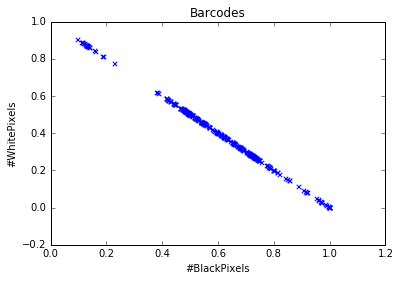

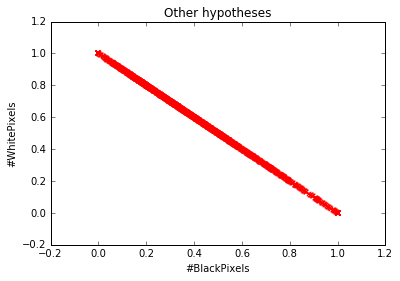

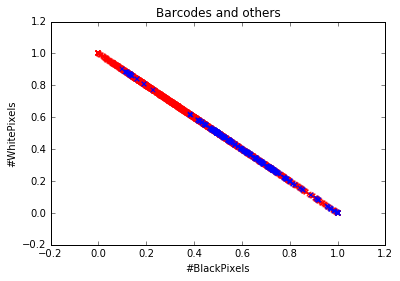

In [5]:
plt.figure(1)
plt.title('Barcodes')
plt.scatter(numOfColoredPixels[True]['Black'],numOfColoredPixels[True]['White'], color = 'b', marker = 'x' )
plt.xlabel('#BlackPixels')
plt.ylabel('#WhitePixels')
savefig('C:\Diplom\Pictures2D\#BlackPixels and #WhitePixels for Barcodes.jpg' )
plt.show()

plt.figure(2)
plt.scatter(numOfColoredPixels[False]['Black'],numOfColoredPixels[False]['White'], color = 'r', marker = 'x' )
plt.title('Other hypotheses')
plt.xlabel('#BlackPixels')
plt.ylabel('#WhitePixels')
savefig('C:\Diplom\Pictures2D\#BlackPixels and #WhitePixels for Other hypotheses.jpg' )
plt.show()

plt.figure(3)
plt.scatter(numOfColoredPixels[False]['Black'],numOfColoredPixels[False]['White'], color = 'r', marker = 'x' )
plt.scatter(numOfColoredPixels[True]['Black'],numOfColoredPixels[True]['White'], color = 'b', marker = 'x' )
plt.title('Barcodes and others')
plt.xlabel('#BlackPixels')
plt.ylabel('#WhitePixels')
savefig('C:\Diplom\Pictures2D\#BlackPixels and #WhitePixels for All hypotheses.jpg' )
plt.show()

In [ ]:
ratioPix = {}
ratioPix[True] = []
ratioPix[False] = []



for i in range(len(numOfColoredPixels[True]['Black'])):
    ratioPix[True].append(numOfColoredPixels[True]['Black'][i] / numOfColoredPixels[True]['White'][i])
for i in range(len(numOfColoredPixels[False]['White'])):
    rat = numOfColoredPixels[False]['Black'][i] / numOfColoredPixels[False]['White'][i]
    rat = rat if rat <= 40 else 40
    ratioPix[False].append(rat)

print(len(ratioPix[False]), len(easySign[False][2]))    

plt.figure(1)
plt.title('Barcodes')
plt.scatter(ratioPix[True], easySign[True][1],  color = 'b', marker = 'x' )
plt.xlabel('Black to white')
plt.ylabel('#ones/#nuls')
savefig('C:\Diplom\Pictures2D\#BlackPixels to #WhitePixels and #ones to # nuls for Barcodes.jpg' )
plt.show()


plt.figure(2)
plt.title('Others')
plt.scatter(ratioPix[False],easySign[False][1], color = 'r', marker = 'x' )
plt.xlabel('Black to white')
plt.ylabel('#ones/#nuls')
plt.show()
savefig('C:\Diplom\Pictures2D\#BlackPixels to #WhitePixels and #ones to # nuls for Other hypotheses.jpg' )
plt.show()

plt.figure(3)
plt.title('Barcodes and others')
plt.scatter(ratioPix[False],easySign[False][1], color = 'r', marker = 'x' )
plt.scatter(ratioPix[True], easySign[True][1],  color = 'b', marker = 'x' )
plt.xlabel('Black to white')
plt.ylabel('#ones/#nuls')
plt.show()
savefig('C:\Diplom\Pictures2D\#BlackPixels to #WhitePixels and #ones to # nuls for All hypotheses.jpg' )
plt.show()    

In [ ]:
plt.figure(1)
plt.scatter(ratioPix[True], stdDev[True],  color = 'b', marker = 'x' )
plt.title('Barcode')
plt.xlabel('#white/#black')
plt.ylabel('StdDev')
savefig('C:\Diplom\Pictures2D\#WhitePixels to #BlackPixels and stdDev for Barcodes.jpg' )
plt.show()

plt.figure(2)
for i in range(len(stdDev[False])):
    if stdDev[False][i] > 25000:
        stdDev[False][i] = 25000

plt.scatter(ratioPix[False],stdDev[False], color = 'r', marker = 'x' )
plt.title('Other')
plt.xlabel('#white/#black')
plt.ylabel('StdDev')
savefig('C:\Diplom\Pictures2D\#WhitePixels to #BlackPixels and stdDev for Other hypotheses.jpg' )
plt.show()

plt.figure(3)
plt.scatter(ratioPix[False],stdDev[False], color = 'r', marker = 'x' )
plt.scatter(ratioPix[True], stdDev[True],  color = 'b', marker = 'x' )
plt.title('Other')
plt.xlabel('#white/#Black')
plt.ylabel('StdDev')
savefig('C:\Diplom\Pictures2D\#WhitePixels to #BlackPixels and stdDev for All hypotheses.jpg' )
plt.show()

In [ ]:
plt.figure(1)
plt.scatter(ratioPix[True], proportions[True],  color = 'b', marker = 'x' )
plt.title('Barcode')
plt.xlabel('White/Black')
plt.ylabel('Proportion of sides')
savefig('C:\Diplom\Pictures2D\#WhitePixels to #BlackPixels and poropotion for Barcodes.jpg' )
plt.show()

plt.figure(2)
plt.title('Other')
plt.scatter(ratioPix[False],proportions[False], color = 'r', marker = 'x' )
plt.xlabel('White/Black')
plt.ylabel('Proportion of sides')
savefig('C:\Diplom\Pictures2D\#WhitePixels to #BlackPixels and proportion for Others.jpg' )
plt.show()

plt.figure(3)
plt.title('Barcodes and others')
plt.scatter(ratioPix[False],proportions[False], color = 'r', marker = 'x' )
plt.scatter(ratioPix[True], proportions[True],  color = 'b', marker = 'x' )
plt.xlabel('White/Black')
plt.ylabel('Proportion of sides')
savefig('C:\Diplom\Pictures2D\#WhitePixels to #BlackPixels and proportion for Barcodes and other Hypotheses.jpg' )
plt.show()    

In [ ]:
from pandas import read_csv, DataFrame
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

df = read_csv("C:\Diplom\data2D_NewVersion5.csv", sep=';', encoding='utf-8')
eigens = {}
eigens[True] = {}
eigens[False] = {}
eigens[True]['l1'] = []
eigens[True]['l2'] = []
eigens[True]['l2/l1'] = []
eigens[False]['l1'] = []
eigens[False]['l2'] = []
eigens[False]['l2/l1'] = []
for i in range (df.shape[0]):
    eigens[df['Label'][i]]['l1'].append(df['L1'][i])
    eigens[df['Label'][i]]['l2'].append(df['L2'][i])
    eigens[df['Label'][i]]['l2/l1'].append(df['L2/L1'][i])

plt.figure(1)
plt.title('Barcodes')
plt.scatter(eigens[True]['l1'], eigens[True]['l2'],  color = 'b', marker = 'x' )
plt.xlabel('l1')
plt.ylabel('l2')
savefig('C:\Diplom\Pictures2D\l1 and l2 for Barcodes.jpg' )
plt.show()

plt.figure(2)
plt.title('Others')
plt.scatter(eigens[False]['l1'], eigens[False]['l2'], color = 'r', marker = 'x' )
plt.xlabel('l1')
plt.ylabel('l2')
savefig('C:\Diplom\Pictures2D\l1 and l2 for Other hypotheses.jpg' )
plt.show()

plt.figure(3)
plt.scatter(eigens[False]['l1'], eigens[False]['l2'], color = 'r', marker = 'x' )
plt.scatter(eigens[True]['l1'], eigens[True]['l2'],  color = 'b', marker = 'x' )
plt.xlabel('l1')
plt.ylabel('l2')
plt.title('Barcodes and others')   
savefig('C:\Diplom\Pictures2D\l1 and l2 for All hypotheses.jpg' )
plt.show()


In [ ]:
std = {}
std[True] = {}
std[False] = {}
std[True]['stdDevBarX'] = []
std[True]['stdDevBarY'] = []
std[False]['stdDevBarX'] = []
std[False]['stdDevBarY'] = []
for i in range (df.shape[0]):
    std[df['Label'][i]]['stdDevBarX'].append(df['L2'][i])
    std[df['Label'][i]]['stdDevBarY'].append(df['StdDevBarX'][i])

plt.figure(1)
plt.title('Barcodes')
plt.scatter(std[True]['stdDevBarX'], std[True]['stdDevBarY'],  color = 'b', marker = 'x' )
plt.xlabel('stdDevBarX')
plt.ylabel('stdDevBarY')
savefig('C:\Diplom\Pictures2D\stdDevBarX and stdDevBarY for Barcodes.jpg' )
plt.show()

plt.figure(2)
plt.title('Others')
plt.scatter(std[False]['stdDevBarX'], std[False]['stdDevBarY'], color = 'r', marker = 'x' )
plt.xlabel('stdDevBarX')
plt.ylabel('stdDevBarY')
savefig('C:\Diplom\Pictures2D\stdDevBarX and stdDevBarY for Other hypotheses.jpg' )
plt.show()

plt.figure(3)
plt.scatter(std[False]['stdDevBarX'], std[False]['stdDevBarY'], color = 'r', marker = 'x' )
plt.scatter(std[True]['stdDevBarX'], std[True]['stdDevBarY'],  color = 'b', marker = 'x' )
plt.xlabel('stdDevBarX')
plt.ylabel('stdDevBarY')
plt.title('Barcodes and others')   
savefig('C:\Diplom\Pictures2D\srdBarX and stdBarY for All hypotheses.jpg' )
plt.show()

In [ ]:
ms = {}
bins = numpy.linspace(0, 36, 36)
for i in range(7):
    ms[i] = {}
ms[1][True] = [df['MeanSquares1'][i] for i in range(df.shape[0]) if df['Label'][i] == True] 
ms[1][False] = [df['MeanSquares1'][i] for i in range(df.shape[0]) if df['Label'][i] == False]
ms[2][True] = [df['MeanSquares2'][i] for i in range(df.shape[0]) if df['Label'][i] == True] 
ms[2][False] = [df['MeanSquares2'][i] for i in range(df.shape[0]) if df['Label'][i] == False]
ms[3][True] = [df['MeanSquares3'][i] for i in range(df.shape[0]) if df['Label'][i] == True] 
ms[3][False] = [df['MeanSquares3'][i] for i in range(df.shape[0]) if df['Label'][i] == False]
ms[4][True] = [df['MeanSquares4'][i] for i in range(df.shape[0]) if df['Label'][i] == True] 
ms[4][False] = [df['MeanSquares4'][i] for i in range(df.shape[0]) if df['Label'][i] == False]
ms[5][True] = [df['MeanSquares127'][i] for i in range(df.shape[0]) if df['Label'][i] == True] 
ms[5][False] = [df['MeanSquares127'][i] for i in range(df.shape[0]) if df['Label'][i] == False]
ms[6][True] = [df['MeanSquares256'][i] for i in range(df.shape[0]) if df['Label'][i] == True] 
ms[6][False] = [df['MeanSquares256'][i] for i in range(df.shape[0]) if df['Label'][i] == False]


for i in range(1,7):
    plt.figure(i, figsize = (25,7))
    plt.subplot(1,2,1), plt.title('MeanSqures' + str(i) + ' Barcodes' ), plt.hist(ms[i][True], bins, alpha=0.5, color = 'b')
    plt.subplot(1,2,2), plt.title('MeanSqures' + str(i) + ' Other hypotheses' ), plt.hist(ms[i][False], bins, alpha=0.5, color = 'r')
    savefig('C:\Diplom\Pictures2D\Distribution' + str(i) + '.jpg' )
    
plt.figure(7, figsize = (25,14))
plt.subplot(2,2,1), plt.scatter(ms[2][True],eigens[True]['l2/l1'], marker = 'x', color = 'b')
plt.subplot(2,2,2), plt.scatter(ms[2][False],eigens[False]['l2/l1'], marker = 'x', color = 'r')
plt.subplot(2,2,3)
plt.scatter(ms[2][False],eigens[False]['l2/l1'], marker = 'x', color = 'r')
plt.scatter(ms[2][True],eigens[True]['l2/l1'], marker = 'x', color = 'b')